In [52]:
"""
    Student:      Byron Dowling
    Class:        Computer Vision (CSE 60535)
    Term:         University of Notre Dame, Fall 2023
    Assignment:   Practical 2: At Home Portion

    Intensity and Shape-based Features for Object Classification

"""
import cv2
import numpy as np
from skimage import measure
from skimage.measure import find_contours
import matplotlib.pyplot as plt

Original Image


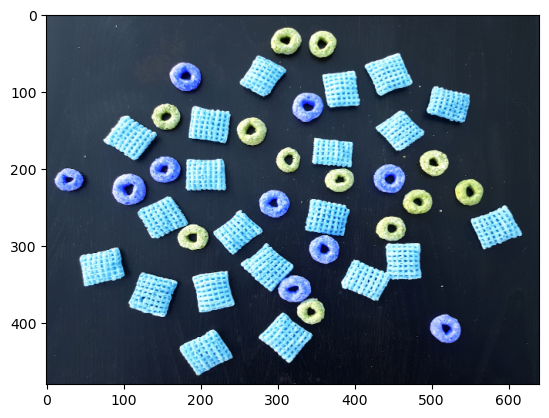

In [71]:
# Read the image into grayscale
sample = cv2.imread('breakfast.png')
sample_small = cv2.resize(sample, (640, 480))

original = sample_small

print("Original Image")
plt.imshow(sample_small)

Grey scale image


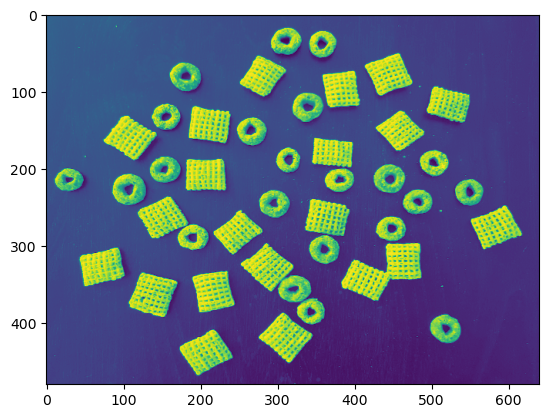

In [54]:
# Convert the original image to grayscale
sample_grey = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

# Show the grey scale image
sample_grey_small = cv2.resize(sample_grey, (640, 480))
print('Grey scale image')
plt.imshow(sample_grey_small)

Image after Otsus thresholding and Floodfill


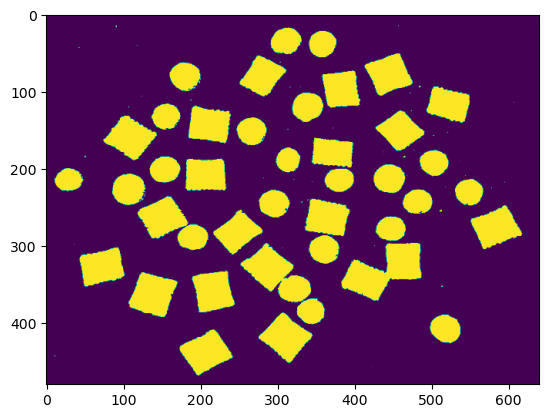

In [56]:
# Binarize the image using Otsu's method
ret1, binary_image = cv2.threshold(src=sample_grey, thresh=0, maxval=255, type=cv2.THRESH_BINARY+cv2.THRESH_OTSU)

im_floodfill = binary_image.copy()
h, w = binary_image.shape[:2]
mask = np.zeros((h+2,w+2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0, 0), 255)
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
binary_image = binary_image | im_floodfill_inv

# Uncomment this to show image after Otsu''s thresholding
sample_small = cv2.resize(src=binary_image, dsize=(640, 480))
print('Image after Otsu''s thresholding and Floodfill')
plt.imshow(sample_small)

Image after Erosion


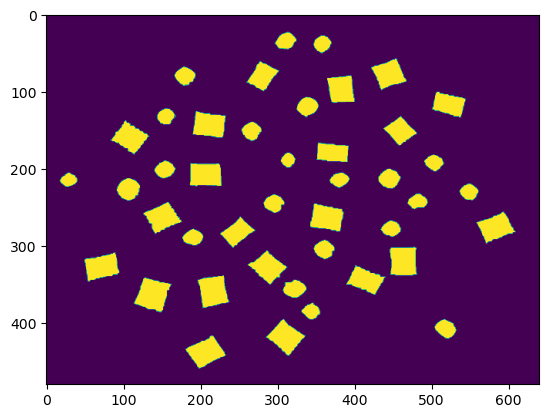

In [57]:
"""
    From here, Otsus thresholding and Floodfill has highlighted
    the circular and squared objects. Now need to apply erosion a bit
    to disconnect some of the overlapped and connected shapes.
"""

ksize = 10      # try something between 5 and 15
sigma = 3       # try something between 2.0 and 4.0
theta = 0.0     # keep it 0.0 if you want to focus on vertically-oriented patterns 
lbd = 3         # try something between 2.0 and 4.0
gamma = 1.0     # keep it 1.0
psi = 0.0       # keep it 0.0

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lbd, gamma, psi, ktype=cv2.CV_32F)

# Normalize the kernel and remove the DC component
kernel /= kernel.sum()
kernel -= kernel.mean()

erosion = cv2.erode(sample_small,kernel,iterations=1)
print("Image after Erosion")
plt.imshow(erosion)

In [ ]:
"""
    Convert the original image to HSV and take H channel for 
    further calculations
"""
sample_hsv = cv2.cvtColor(sample, cv2.COLOR_BGR2HSV)
sample_h = sample_hsv[:, :, 0]

# Uncomment this to show the H channel of the image
sample_small = cv2.resize(sample_h, (640, 480))
print('H channel of the image')
# plt.imshow(sample_small)

"""
    Similar to the at home task, my hypothesis is that pixel area will easily
    distinguish between the donut shapes and the square shapes. 
"""

labels = measure.label(erosion,1)
properties = measure.regionprops(labels, intensity_image=sample_small)

object_areas = [obj["area"] for obj in properties if obj["area"] > 100 and obj["area"] < 274000]

"""
    Based on the histogram in the next cell, obtained these area ranges for the
    donut shapes and the square shapes.
"""
potentialDonuts = [obj for obj in properties if obj["area"] >100 and obj["area"] <700]
potentialSquares = [obj for obj in properties if obj["area"] >700 and obj["area"] <1400]

combined = []
combined = potentialDonuts + potentialSquares

# Had to print a few of the object areas to get a feel for the max and min values
print(f"Total number of objects: {len(object_areas)}")

for count, obj in enumerate(potentialDonuts):
    print(obj["max_intensity"])
    print(obj["mean_intensity"])
    print(obj["min_intensity"])
    print()

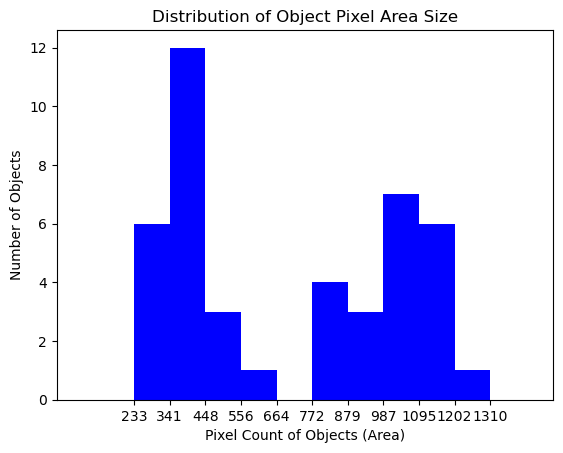

In [92]:
# Drawing a histogram of the areas of the objects
hist, bin_edges,_=plt.hist(object_areas, color='blue')
plt.title("Distribution of Object Pixel Area Size")
plt.xlabel("Pixel Count of Objects (Area)")
plt.ylabel("Number of Objects")
plt.xlim(0,1500)
plt.xticks(bin_edges[0:])
plt.show()

In [ ]:
"""
    Confirming we've found the correct shapes by pixel area

    Printing out each individual object to make sure they are correct. This
    was helpful when before the image flooding was applied, the objects were
    including the "donut holes" and a one or two connected square pieces.
"""
for index, obj in enumerate(potentialDonuts):
    # for each object, print out its centroid and print the object itself
    print("Coordinates of the object number {} is {}".format(index+1, np.round(obj['centroid'],2)))
    mask = np.zeros(shape=obj['image'].shape)
    mask[obj['image']]=1
    plt.figure(figsize=(2,2))
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.show()
    print(f'Object Area {obj["area"]}')

for index, obj in enumerate(potentialSquares):
    # for each object, print out its centroid and print the object itself
    print("Coordinates of the object number {} is {}".format(index+1, np.round(obj['centroid'],2)))
    mask = np.zeros(shape=obj['image'].shape)
    mask[obj['image']]=1
    plt.figure(figsize=(2,2))
    plt.imshow(mask, cmap=plt.cm.gray)
    plt.show()
    print(f'Object Area {obj["area"]}')

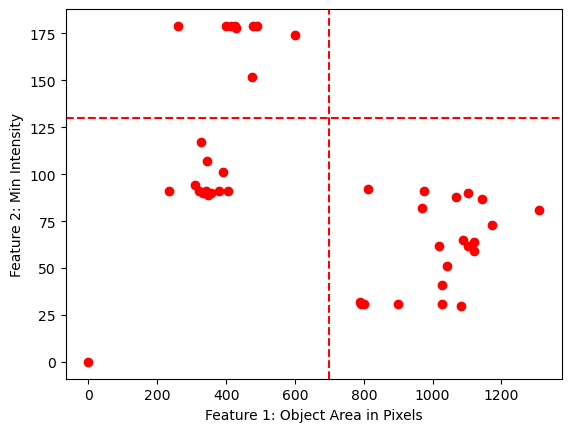

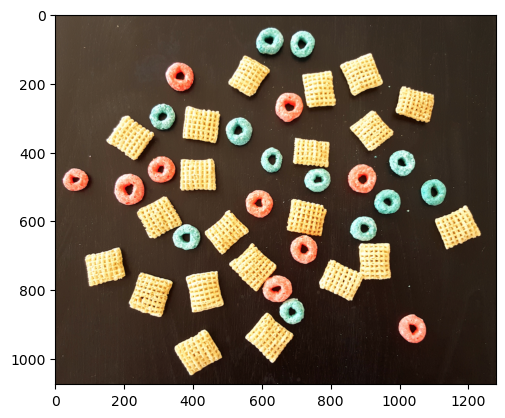

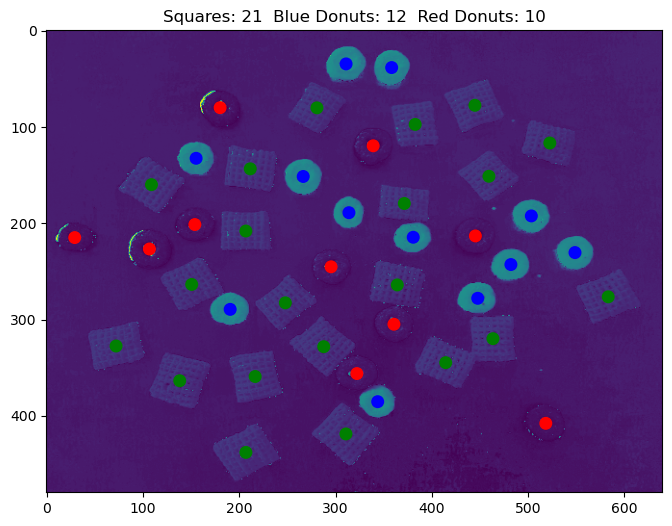

In [93]:
import matplotlib.patches as mpatches

# *** TASK *** Calculate features for each object:
# - some geometrical feature 1 : Pixel Area
# - some intensity/color-based feature 2 : Max Intensity

features = np.zeros((len(potentialDonuts) + len(potentialSquares),2))

startingPoint = 0

for index, obj in enumerate(potentialDonuts):
    features[index, 0] = obj["area"]
    features[index, 1] = obj["max_intensity"]
    startingPoint = index

for index, obj in enumerate(potentialSquares):
    features[index + startingPoint, 0] = obj["area"]
    features[index + startingPoint, 1] = obj["max_intensity"]

# *** TASK *** Show our objects in the feature space
plt.plot(features[:, 0],features[:, 1], 'ro')
plt.xlabel('Feature 1: Object Area in Pixels')
plt.ylabel('Feature 2: Min Intensity')

# *** TASK *** Choose the threshold
thrF1 = 700
thrF2 = 130

plt.axvline(x=thrF1,color='r',linestyle='dashed')
plt.axhline(y=thrF2,color='r',linestyle='dashed')
plt.show()


# It's time to classify, count and display the objects
squares = 0
blue_circles = 0
red_circles = 0

fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))


fig, ax = plt.subplots(figsize=(10, 6))

for index, obj in enumerate(potentialSquares):
    dot = mpatches.Circle((obj["centroid"][1], obj["centroid"][0]), radius=6, 
                           fill=True, color='green')
    ax.add_patch(dot)
    squares += 1

for index, obj in enumerate(potentialDonuts):
    if obj["max_intensity"] > thrF2:
        dot = mpatches.Circle((obj["centroid"][1], obj["centroid"][0]), radius=6, 
                            fill=True, color='red')
        ax.add_patch(dot)
        red_circles += 1
    else:
        dot = mpatches.Circle((obj["centroid"][1], obj["centroid"][0]), radius=6, 
                            fill=True, color='blue')
        ax.add_patch(dot)
        blue_circles += 1

plt.title(f"Squares: {squares}  Blue Donuts: {blue_circles}  Red Donuts: {red_circles}")
plt.imshow(sample_small)